In [1]:
# # %%capture
# !pip install unsloth
# # # Also get the latest nightly Unsloth!
# !pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

In [2]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    # "scb10x/typhoon2-qwen2vl-7b-vision-instruct",
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Unsloth: Your Flash Attention 2 installation seems to be broken?
A possible explanation is you have a new CUDA version which isn't
yet compatible with FA2? Please file a ticket to Unsloth or FA2.
We shall now use Xformers instead, which does not have any performance hits!
We found this negligible impact by benchmarking on 1x A100.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.1.8: Fast Qwen2_Vl vision patching. Transformers: 4.48.2.
   \\   /|    GPU: NVIDIA H200. Max memory: 139.827 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [3]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.model` require gradients


<a name="Data"></a>
### Data Prep
We'll be using a sampled dataset of handwritten maths formulas. The goal is to convert these images into a computer readable form - ie in LaTeX form, so we can render it. This can be very useful for complex formulas.

You can access the dataset [here](https://huggingface.co/datasets/unsloth/LaTeX_OCR). The full dataset is [here](https://huggingface.co/datasets/linxy/LaTeX_OCR).

In [4]:
from datasets import load_dataset

dataset = load_dataset("Tuch/food_and_travel", split = "train")
dataset = dataset.select(range(0, 70000))
dataset


Dataset({
    features: ['image', 'caption'],
    num_rows: 70000
})

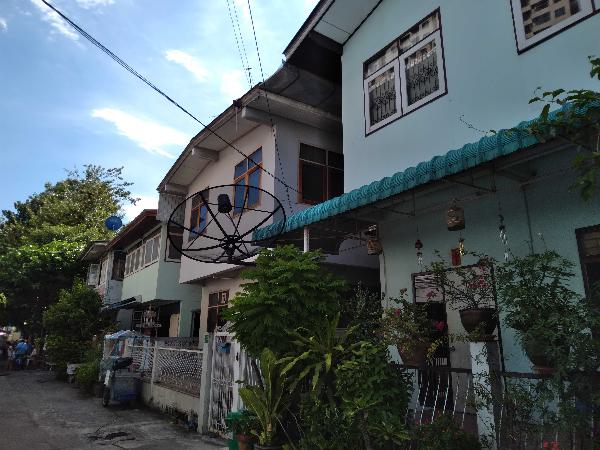

In [5]:
dataset[0]["image"]

Let's take an overview look at the dataset. We shall see what the 3rd image is, and what caption it had.

In [6]:
dataset[0]["caption"]

'อาคารสีฟ้ามีจานดาวเทียวทั้งอยู่ด้านหลังของบ้านเป็นจานสีดำ'

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": Q}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": A} ]
},
]
```

In [7]:
instruction = "คิดแคปชั่นรูปนี้ให้หน่อย"

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"].convert('RGB')} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["caption"]} ]
        },
    ]
    return { "messages" : conversation }


In [8]:

from tqdm import tqdm

converted_dataset = [convert_to_conversation(sample) for sample in tqdm(dataset)]

100%|██████████| 70000/70000 [02:03<00:00, 567.74it/s]


In [9]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text', 'text': 'คิดแคปชั่นรูปนี้ให้หน่อย'},
    {'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=600x450>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'อาคารสีฟ้ามีจานดาวเทียวทั้งอยู่ด้านหลังของบ้านเป็นจานสีดำ'}]}]}

Let's convert the dataset into the "correct" format for finetuning:

In [10]:
#converted_dataset

In [11]:
converted_dataset[0]['messages'][1]

{'role': 'assistant',
 'content': [{'type': 'text',
   'text': 'อาคารสีฟ้ามีจานดาวเทียวทั้งอยู่ด้านหลังของบ้านเป็นจานสีดำ'}]}

Let's first see before we do any finetuning what the model outputs for the first example!

In [12]:
# FastVisionModel.for_inference(model) # Enable for inference!

# image = dataset[10]["image"]
# instruction = "คิดแคปชั่นรูปนี้ให้หน่อย"

# messages = [
#     {"role": "user", "content": [
#         {"type": "image"},
#         {"type": "text", "text": instruction}
#     ]}
# ]
# input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
# inputs = tokenizer(
#     image,
#     input_text,
#     add_special_tokens = False,
#     return_tensors = "pt",
# ).to("cuda")

# from transformers import TextStreamer
# text_streamer = TextStreamer(tokenizer, skip_prompt = True)
# _ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 512,
#                    use_cache = True, temperature = 0.8, min_p = 0.1)

In [13]:
#image

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [33]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size =22 ,
        gradient_accumulation_steps = 1,
        warmup_steps = 5,
        max_steps = 10,
        num_train_epochs = 5, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 8,
        max_seq_length = 2048,
    ),
)

In [28]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA H200. Max memory = 139.827 GB.
129.643 GB of memory reserved.


In [34]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 70,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 22 | Gradient Accumulation steps = 1
\        /    Total batch size = 22 | Total steps = 10
 "-____-"     Number of trainable parameters = 40,370,176
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Step,Training Loss
1,0.862000
2,0.756400
3,0.815500
4,0.755900
5,0.753300
6,0.701800
7,0.723700
8,0.739300
9,0.715400
10,0.748900


In [35]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

90.5549 seconds used for training.
1.51 minutes used for training.
Peak reserved memory = 129.719 GB.
Peak reserved memory for training = 0.076 GB.
Peak reserved memory % of max memory = 92.771 %.
Peak reserved memory for training % of max memory = 0.054 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [ ]:
import torch
from PIL import Image
from transformers import TextStreamer

def run_inference_on_image(model, tokenizer, image_path, instruction):
    """
    Runs inference on a single image given its file path and an instruction prompt.
    
    Args:
        model: The FastVisionModel (or compatible) model instance.
        tokenizer: The tokenizer associated with the model.
        image_path (str): Path to the image file.
        instruction (str): The text instruction or question about the image.
    
    Returns:
        The generated text response as a string.
    """
    # 1) Ensure the model is in inference mode
    #    FastVisionModel.for_inference(model) 
    #    (Uncomment if needed; depends on how your pipeline is set up)
    
    # 2) Load the image from disk
    image = Image.open(image_path).convert("RGB")
    
    # 3) Prepare chat messages
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": instruction}
            ]
        }
    ]
    
    # 4) Format input text using your chat template
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

    # 5) Create tokenized inputs (image + text)
    #    Make sure the tokenizer can handle image inputs properly.
    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt"
    ).to("cuda" if torch.cuda.is_available() else "cpu")

    # 6) Create a streamer for token-by-token output (or just generate normally)
    text_streamer = TextStreamer(tokenizer, skip_prompt=True)

    # 7) Generate the model output
    #    Note: text_streamer will print tokens as they are generated.
    #    If you want to capture the full output string, decode it afterward.
    outputs = model.generate(
        **inputs,
        streamer=text_streamer,
        max_new_tokens=64,
        use_cache=True,
        temperature=1.5,
        min_p=0.1
    )

    # 8) Decode the final output if you want a return string
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return decoded


image_path = "path_to_your_image.jpg"
prompt = "Is there something interesting about this image?"
response = run_inference_on_image(model, tokenizer, image_path, prompt)
print("Model response:", response)


In [36]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "คิดแคปชั่นรูปนี้ให้หน่อย"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 256,
                   use_cache = True, temperature = 0.1, min_p = 0.1)

บ้านสีขาวและสีฟ้าตั้งอยู่ในหมู่บ้านที่มีต้นไม้และต้นไม้สีเขียว<|im_end|>


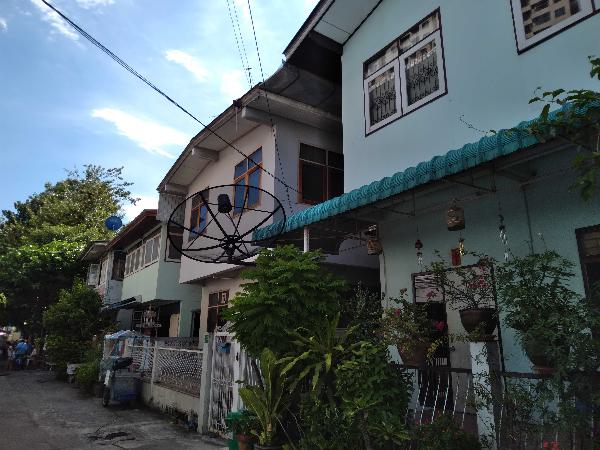

In [19]:
image

In [47]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[901]["image"]
cap   = dataset[901]["caption"]
instruction = "คิดแคปชั่นรูปนี้ให้หน่อย"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 256,
                   use_cache = True, temperature = 0.5, min_p = 0.1)

อาคารไม้สีน้ำตาลขนาดใหญ่หลายหลังมีเสาไม้สีน้ำตาลหลายต้น<|im_end|>


In [48]:
cap 

'บ้านไม้มีบันได มีใต้ถุนบ้าน ใต้ถุนบ้านมีเสาหลายต้น มีหลอดไฟ'

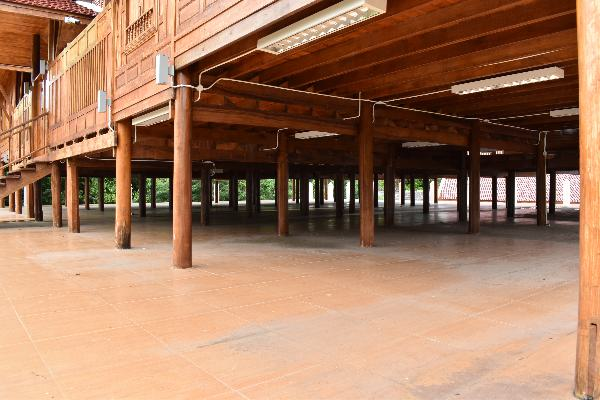

In [49]:
image

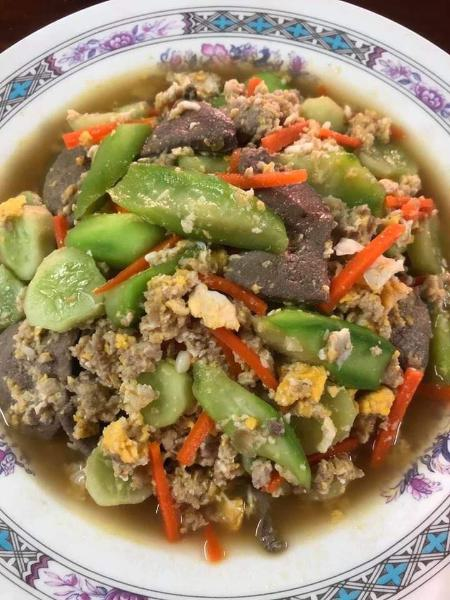

In [21]:
image

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

In [22]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

[]